In [1]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import netket as nk
import optax
import netket.jax as nkjax
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os
import json
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate

from grad_sample.tasks.fullsum_train import Trainer
from grad_sample.utils.is_distrib import *
from grad_sample.utils.plotting_setup import *
from grad_sample.is_hpsi.expect import *
from grad_sample.is_hpsi.qgt import QGTJacobianDenseImportanceSampling
from grad_sample.is_hpsi.operator import IS_Operator
from netket.jax._jacobian.logic import _multiply_by_pdf
from grad_sample.utils.tree_op import dagger_pytree, vjp_pytree, mul_pytree, shape_tree, pytree_mean
from grad_sample.tasks.fullsum_snr_is import _compute_S_F, _compute_S_F_var

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import seaborn as sns
sns.set_context('talk', font_scale=1.1)

In [4]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="train_is")
    OmegaConf.set_struct(cfg, True)
    print(cfg)
    print(cfg.task)
    # cfg = OmegaConf.to_yaml(cfg)
    # take any task from cfg and run it
# analysis = FullSumPruning(cfg)
trainer = Trainer(cfg)

{'device': '4', 'is_mode': 2.0, 'lr': 0.0022, 'diag_shift': 0.0001, 'n_iter': 2000, 'sample_size': 9, 'chunk_size_jac': 1024, 'chunk_size_vmap': 100, 'save_every': None, 'run_index': None, 'base_path': '/scratch/.amisery/grad_sample_test/', 'model': {'_target_': 'grad_sample.models.heisenberg.XXZ', 'h': 1.5, 'L': 16}, 'ansatz': {'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}, 'task': {'_target_': 'grad_sample.tasks.fullsum_train.Trainer'}, 'solver_fn': {'_target_': 'netket.optimizer.solver.cholesky'}, 'sampler': {'_target_': 'netket.sampler.ExactSampler'}}
{'_target_': 'grad_sample.tasks.fullsum_train.Trainer'}
[CudaDevice(id=0)]
{'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}
MC state loaded, num samples 512
/scratch/.amisery/grad_sample_test//xxz_1.5/L16/RBM/alpha3/MC_9_2.0/0.0022_0.0001/run_3
The ground state energy is: -33.71105604086474


In [5]:
a = jnp.ones(5)
b = jnp.ones(5)*2
c = jnp.stack([a,b])
print(c)
print(c.shape)
print(c.T.shape)
jax.lax.collapse(c.T,0,2)

[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]]
(2, 5)
(5, 2)


Array([1., 2., 1., 2., 1., 2., 1., 2., 1., 2.], dtype=float64)

In [6]:
import advanced_drivers as advd
def print_alpha_cb(step, logdata, driver):
    if step %10 == 0:
        print(driver._ham.is_mode)
    return True
gs = advd.driver.VMC_NG_IS(hamiltonian=trainer.is_op, optimizer=trainer.opt, variational_state=trainer.vstate, diag_shift=1e-4)

In [7]:
gs.run(n_iter=3000, callback= (print_alpha_cb,),)

  0%|          | 0/3000 [00:00<?, ?it/s]

(512, 2, 1664)
dv shape
(1024,)
reshaping
force unrolled shape
(1664, 512)


  0%|          | 2/3000 [00:08<3:37:43,  4.36s/it, Energy=15.449-0.009j ± 0.094 [σ²=3.929]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  0%|          | 8/3000 [00:08<02:03, 24.23it/s, Energy=14.86-0.00j ± 0.12 [σ²=5.99]]      

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  0%|          | 14/3000 [00:09<01:57, 25.35it/s, Energy=14.61-0.01j ± 0.13 [σ²=9.29]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  1%|          | 20/3000 [00:09<01:55, 25.69it/s, Energy=14.30+0.01j ± 0.22 [σ²=13.82]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  1%|          | 26/3000 [00:09<01:55, 25.68it/s, Energy=12.93-0.00j ± 0.27 [σ²=21.00]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  1%|          | 31/3000 [00:09<01:56, 25.57it/s, Energy=11.67+0.01j ± 0.25 [σ²=36.67]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  1%|          | 37/3000 [00:10<01:58, 25.08it/s, Energy=9.10+0.02j ± 0.33 [σ²=65.45]] 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  1%|▏         | 44/3000 [00:10<01:56, 25.32it/s, Energy=4.26-0.07j ± 0.42 [σ²=101.20]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  2%|▏         | 49/3000 [00:10<01:56, 25.37it/s, Energy=-1.58+0.03j ± 0.50 [σ²=151.24]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  2%|▏         | 55/3000 [00:10<01:57, 25.11it/s, Energy=-9.28+0.10j ± 0.52 [σ²=175.81]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  2%|▏         | 59/3000 [00:10<01:56, 25.23it/s, Energy=-11.26+0.10j ± 0.70 [σ²=218.42]]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

  2%|▏         | 60/3000 [00:11<03:36, 13.55it/s, Energy=-13.22-0.00j ± 0.49 [σ²=162.96]]

var ratio : 1.9999999999999996
snr ratio : 1.2272918757899336
grad snr ratio : 1.2412680033581223
1.8953156983482806


  2%|▏         | 60/3000 [00:12<10:15,  4.78it/s, Energy=-13.22-0.00j ± 0.49 [σ²=162.96]]

Stopped by user.


()

In [8]:
from netket.vqs import FullSumState
import copy
fs_state = FullSumState(hilbert = gs.state.hilbert, model = gs.state.model, chunk_size=None, seed=0)
fs_state.variables = copy.deepcopy(gs.state.variables)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [9]:
# estimate local grad
pdf = fs_state.probability_distribution()
vstate_arr = fs_state.to_array()
Hloc = trainer.model.hamiltonian.to_sparse() @ vstate_arr / vstate_arr
Hloc_c = (Hloc - jnp.sum(Hloc*pdf))
mode = "holomorphic"
# uncentered jacobian
jacobian_orig = nkjax.jacobian(
    fs_state._apply_fun,
    fs_state.parameters,
    fs_state.hilbert.all_states(), #in MC state, this is vstate.samples
    fs_state.model_state,
    pdf=pdf,
    mode=mode,
    dense=True,
    center=False,
    chunk_size=10,
    _sqrt_rescale=False, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [10]:
jacobian_orig_c = jacobian_orig - jnp.sum(jacobian_orig*pdf[:,None],axis=0)
loc_grad = pdf * jacobian_orig.conj().T * Hloc_c
loc_grad_c = pdf * jacobian_orig_c.conj().T * Hloc_c
loc_grad_rescaled = loc_grad / jnp.sum(jnp.abs(loc_grad), axis= 1)[:,None]
mean_grad = jnp.abs(jnp.mean(jnp.abs(loc_grad_rescaled), axis=0))

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [11]:
# with reweighting |\psi|
alpha = 1
mod_pdf = jnp.abs(vstate_arr)**alpha/jnp.sum(jnp.abs(vstate_arr)**alpha)
# plt.plot(mod_1_pdf)
# plt.yscale('log')
def mod_pdf_fun(alpha):
    return (jnp.abs(vstate_arr)**alpha)/jnp.sum(jnp.abs(vstate_arr)**alpha)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [12]:
def kl_dist(p1, p2):
    return jnp.sum(p1 * jnp.log(p1/p2))

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

Text(0.5, 1.0, 'KL divergence between mean "optimal" distribution and overdispersed pdf $q_\\alpha$')

Error in callback <function _draw_all_if_interactive at 0x7f65ea415c60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

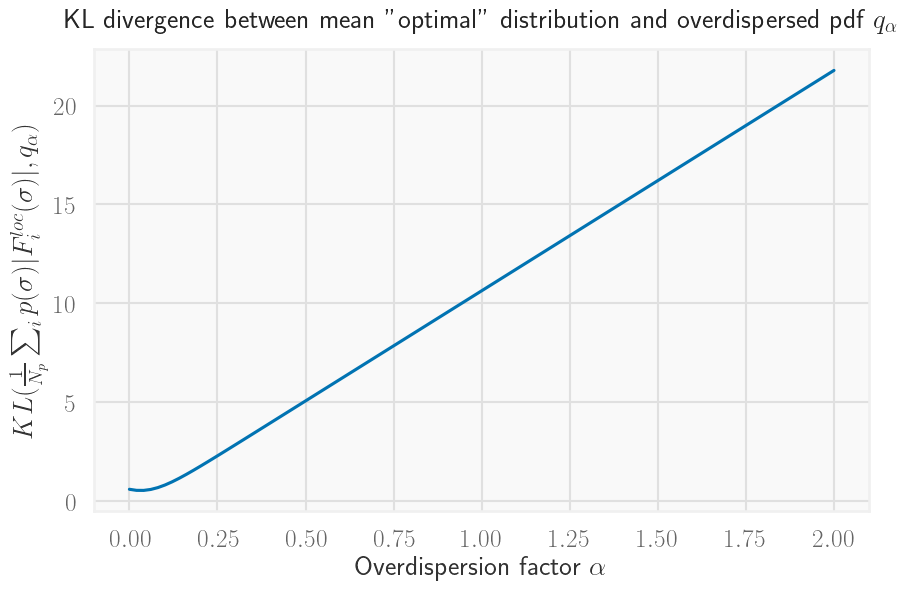

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [13]:
plt.plot(jnp.linspace(0,2,100), [kl_dist(mean_grad, mod_pdf_fun(a)) for a in jnp.linspace(0,2,100)])
plt.ylabel(r'$KL(\frac{1}{N_p}\sum_i p(\sigma)|F_i^{loc}(\sigma)|, q_\alpha)$')
plt.xlabel(r'Overdispersion factor $\alpha$')
plt.title(r'KL divergence between mean "optimal" distribution and overdispersed pdf $q_\alpha$')

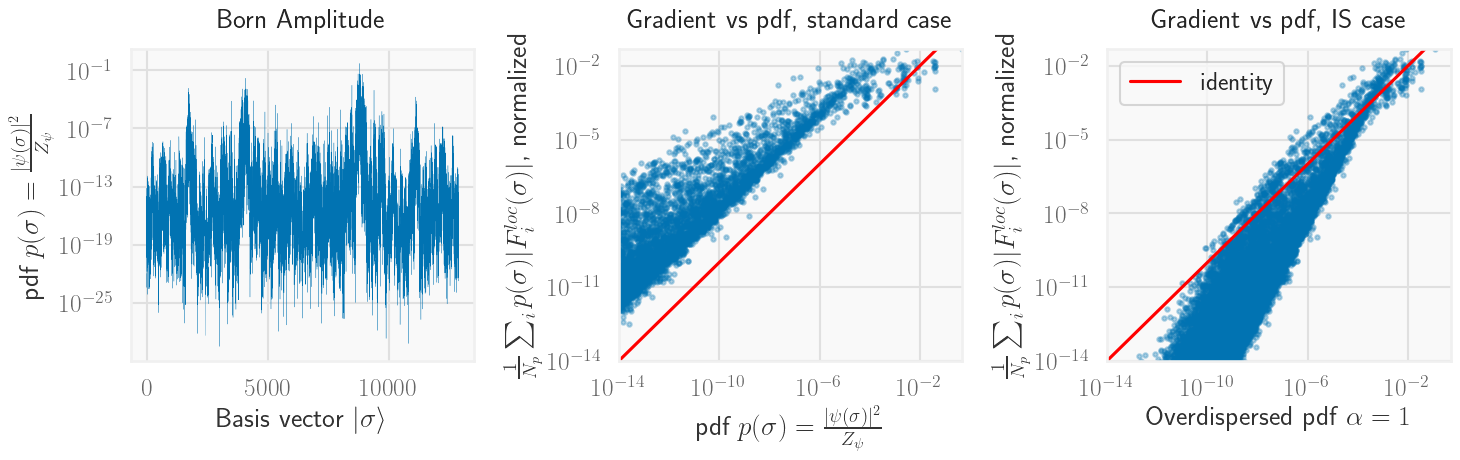

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# plt.plot(jnp.mean(loc_grad, axis=0))
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(pdf, linewidth=0.2)
axes[0].set_yscale('log')
axes[1].set_xscale('log')
axes[0].set_xlabel(r'Basis vector $\ket{\sigma}$')
axes[0].set_ylabel(r'pdf $p(\sigma) = \frac{|\psi(\sigma)|^2}{Z_\psi}$')
axes[0].set_title('Born Amplitude')
axes[1].set_yscale('log')

axes[1].scatter(pdf, mean_grad, alpha=0.3, s=10)
# axes[1].scatter(pdf, jnp.abs(loc_grad_rescaled[0]))
id_y = jnp.linspace(min(mean_grad), max(mean_grad), 10)
axes[1].plot(id_y, id_y, color = 'red')
axes[1].set_ylabel(r'$\frac{1}{N_p}\sum_i p(\sigma)|F_i^{loc}(\sigma)|$, normalized')
axes[1].set_xlabel(r'pdf $p(\sigma) = \frac{|\psi(\sigma)|^2}{Z_\psi}$')
axes[1].set_title('Gradient vs pdf, standard case')

# axes[0].set_ylim(1e-14, max(pdf))
axes[1].set_ylim(1e-14, max(mean_grad))
axes[2].set_ylim(1e-14, max(mean_grad))
axes[1].set_xlim(1e-14, max(pdf))
axes[2].set_xlim(1e-14, max(pdf))

axes[2].plot(id_y, id_y, color = 'red', label = 'identity')
axes[2].scatter(mod_pdf, mean_grad, alpha=0.3, s=10)
axes[2].set_title('Gradient vs pdf, IS case')
axes[2].set_ylabel(r'$\frac{1}{N_p}\sum_i p(\sigma)|F_i^{loc}(\sigma)|$, normalized')
axes[2].set_xlabel(r'Overdispersed pdf $\alpha = 1$')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
plt.legend()
fig.tight_layout()

In [14]:
import copy

def apply_gradient(optimizer_fun, optimizer_state, dp, params):
    updates, new_optimizer_state = optimizer_fun(dp, optimizer_state, params)

    new_params = optax.apply_updates(params, updates)

    return new_optimizer_state, new_params
    return True

def rel_err_fs(vstate, fs_state, is_op, e_gs):
    fs_state.variables = copy.deepcopy(vstate.variables)
    # e = fs_state.expect(driver._ham.operator).mean.real
    e = fs_state.expect(is_op.operator).mean.real
    return jnp.abs(e-e_gs)/jnp.abs(e_gs)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [15]:
import numpy as np
from tqdm import tqdm
from netket.vqs import FullSumState

def train_adapt(update_type='opt', update_stride=10, alpha_s=2.0, n_iter=2000):  
    '''
    Typical params
    update_type = 'opt' #opt or heur
    update_stride = 10

    update_type = 'heur' #opt or heur
    update_stride = 2
    '''
    # Initialize variables
    warmup = 50
    lr = 0.005
    epsilon = 1e-8  # Small constant to prevent division by zero
    stride_rel_err = 20
    # Define the optimizer
    # alpha_opt = optax.adam(learning_rate=0.03, eps=1e-8)  # Adagrad optimizer
    alpha_opt = optax.sgd(learning_rate=0.05)
    alpha_opt_state = alpha_opt.init(alpha_s) 

    fs_state_rel_err = FullSumState(hilbert = trainer.vstate.hilbert, model = trainer.vstate.model, chunk_size=None, seed=0)
        
    al = []
    itvar = []
    snrl = []
    gradvarl = []
    itrel = []
    rel_errl = []
    is_ops = IS_Operator(operator=trainer.model.hamiltonian.to_jax_operator(), is_mode=alpha_s)
    # trainer.vstate.init_parameters(seed=0)
    trainer.vstate.init_parameters()
    opt_state = trainer.opt.init(trainer.vstate.parameters)

    with tqdm(
                    total=n_iter,
                    disable=False,
                    dynamic_ncols=True,
                ) as pbar:
        # Optimization loop
        for n in tqdm(range(n_iter)):
            # Create IS operator and get log importance weights
            log_qs, log_qs_vars = is_ops.get_log_importance(trainer.vstate)
            
            # Sample from the distribution
            samples_alphas = trainer.vstate.sample_distribution(
                log_qs,
                variables=log_qs_vars,
                n_samples=trainer.Nsample
            )
            if n%update_stride ==1 and n > warmup:
                O_exp, O_grad, ng, snr, grad_var = _compute_S_F_var(
                samples_alphas,
                trainer.vstate._apply_fun,
                trainer.vstate.parameters,
                trainer.vstate.model_state,
                log_qs,
                log_qs_vars,
                trainer.chunk_size_jac // 2,
                is_ops,
                trainer.solver_fn,
                1e-4,
                )  
                # Compute mean of variance and gradient variance
                snrl.append(pytree_mean(snr))
                grad_var_mean = pytree_mean(grad_var)
                gradvarl.append(grad_var_mean)
                al.append(alpha_s)

                itvar.append(n)

                if update_type == 'opt':
                    # optax update
                    updates, alpha_opt_state = alpha_opt.update(grad_var_mean, alpha_opt_state)
                    alpha_s_new = optax.apply_updates(alpha_s, updates)  # Update alpha_s
                    if alpha_s_new > 0:
                        alpha_s = alpha_s_new
                        is_ops._is_mode = alpha_s 
                # heuristic update
                elif update_type == 'heur':
                    if grad_var_mean > 0:
                        alpha_s_new = alpha_s - lr
                    else:
                        alpha_s_new = alpha_s + lr
                    
                    if alpha_s_new > 0:
                        alpha_s = alpha_s_new
                        is_ops._is_mode = alpha_s 
                    # is_ops = IS_Operator(operator=trainer.model.H_jax, is_mode=alpha_s)

            else:
                O_exp, O_grad, ng = _compute_S_F(
                samples_alphas,
                trainer.vstate._apply_fun,
                trainer.vstate.parameters,
                trainer.vstate.model_state,
                log_qs,
                log_qs_vars,
                trainer.chunk_size_jac // 2,
                is_ops,
                trainer.solver_fn,
                1e-4,
                )  

            opt_state, trainer.vstate.parameters = apply_gradient(trainer.opt.update, opt_state, ng[0], trainer.vstate.parameters)
            
            if n%stride_rel_err == 0:
                rel_errl.append(rel_err_fs(trainer.vstate, fs_state_rel_err, is_ops, trainer.E_gs))
                itrel.append(n)
            pbar.set_postfix_str(
                        "E = %s ; alpha = %.2f"%(O_exp, alpha_s)
                        )
            pbar.update(1)

    return al, itvar, snrl, gradvarl, itrel, rel_errl

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
for i in range(5):
    al, itvar, snrl, gradvarl, itrel, rel_errl = train_adapt(update_type='opt', update_stride=10, alpha_s=1.0, n_iter=8000)
    out_dict = {'al': al, 'itvar': itvar, 'snrl': snrl, 'gradvarl': gradvarl, 'itrel': itrel, 'rel_errl': rel_errl}
    jnp.savez(f"run_1_start_{i}.npz", out_dict )

 14%|█▍        | 1152/8000 [00:57<05:39, 20.17it/s, E = -33.70779217298035 ; alpha = 1.00]


KeyboardInterrupt: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [18]:
al, itvar, snrl, gradvarl, itrel, rel_errl = train_adapt(update_type='opt', update_stride=10, alpha_s=2.0)
al_f, itvar_f, snrl_f, _, itrel_f, rel_errl_f = train_adapt(update_type='none', alpha_s=1.0)
al_def, itvar_def, snrl_def, _, itrel_def, rel_errl_def = train_adapt(update_type='none', alpha_s=2.0)

100%|██████████| 2000/2000 [01:16<00:00, 26.03it/s, E = -26.478017448802426 ; alpha = 2.00]


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

Text(0, 0.5, '$\\frac{1}{N_p}\\sum_j\\frac{Var(F_j)}{|F_j|^2}$')

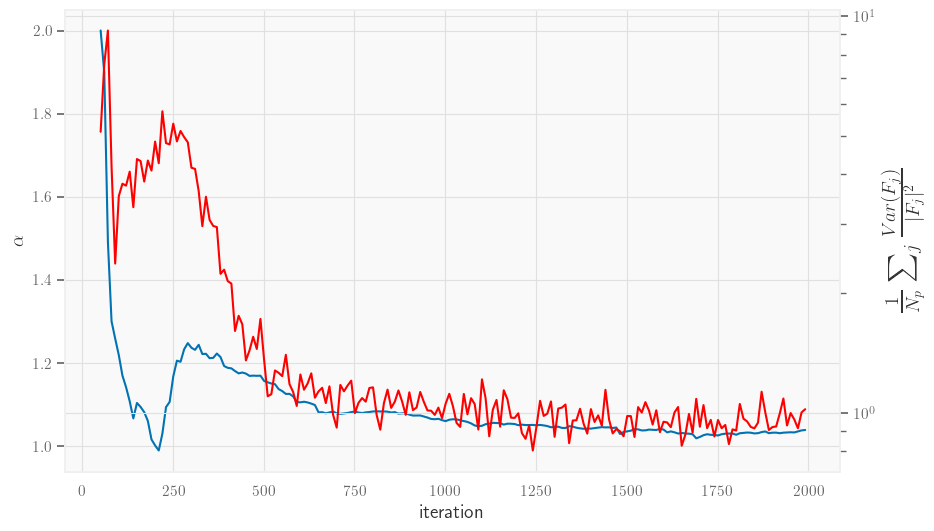

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [19]:
fig, axes = plt.subplots()
axes.plot(itvar, al)
axes1 = axes.twinx()
axes1.plot(itvar, jnp.array(snrl), color='red', label = r'Mean SNR, adaptive $\alpha$')

axes1.set_yscale('log')

axes.set_xlabel('iteration')
axes.set_ylabel(r'$\alpha$')
axes1.set_ylabel(r'$\frac{1}{N_p}\sum_j\frac{Var(F_j)}{|F_j|^2}$', fontsize=20)

# fig.suptitle(r'Automatic tuning of $\alpha$, update every %d, warmup of %d steps, heuristic step %.2f'%(update_stride, warmup, lr))

Text(0, 0.5, '$\\frac{1}{N_p}\\sum_j\\frac{Var(F_j)}{|F_j|^2}$')

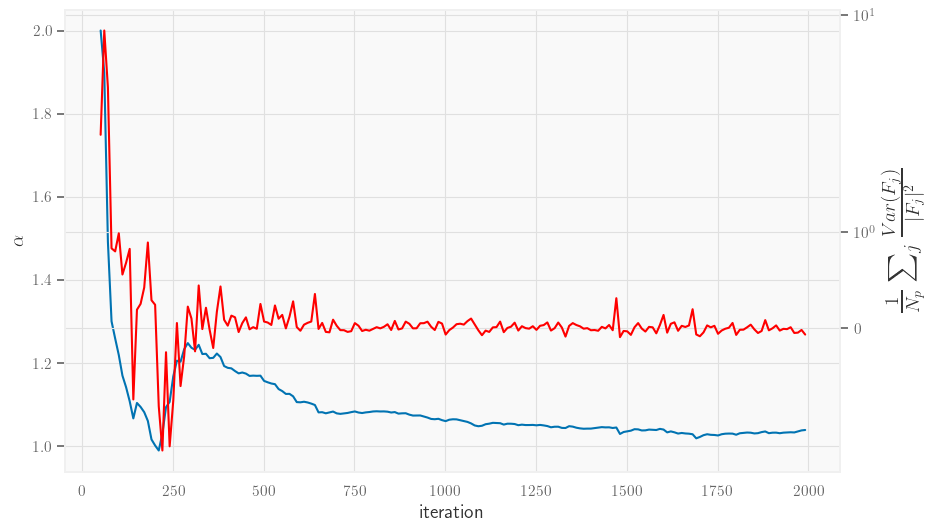

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [20]:
fig, axes = plt.subplots()
axes.plot(itvar, al)
axes1 = axes.twinx()
axes1.plot(itvar, jnp.array(gradvarl), color='red', label = r'Mean SNR, adaptive $\alpha$')

axes1.set_yscale('symlog')

axes.set_xlabel('iteration')
axes.set_ylabel(r'$\alpha$')
axes1.set_ylabel(r'$\frac{1}{N_p}\sum_j\frac{Var(F_j)}{|F_j|^2}$', fontsize=20)

Text(0.5, 0.98, 'Relative error and gradient variance, no tuning')

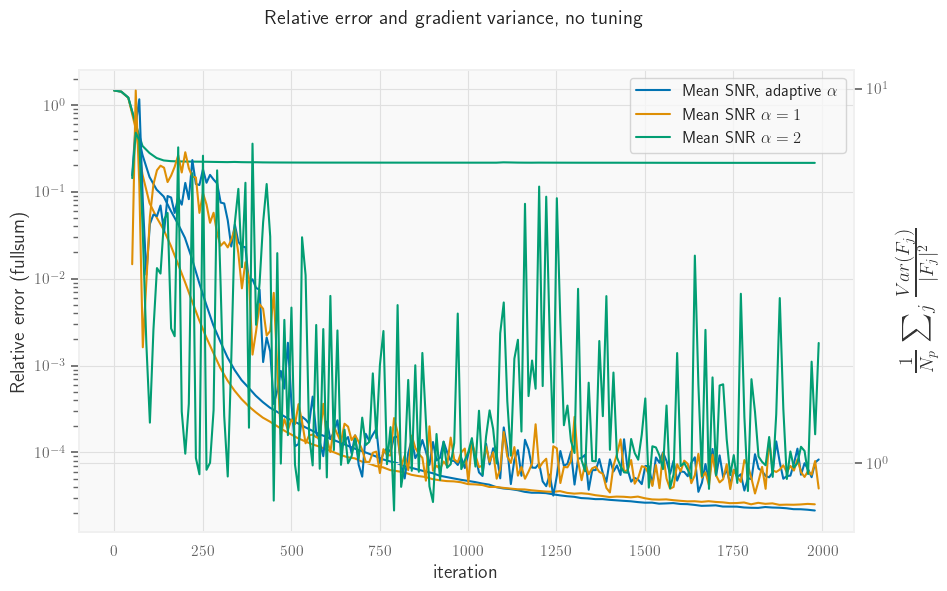

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [22]:
fig, axes = plt.subplots()

axes.plot(itrel, rel_errl)
axes.plot(itrel_f, rel_errl_f)
axes.plot(itrel_def, rel_errl_def)
axes.set_yscale('log')
axes1 = axes.twinx()
axes1.plot(itvar, jnp.array(snrl),  label = r'Mean SNR, adaptive $\alpha$')
axes1.plot(itvar_f, jnp.array(snrl_f), label = r'Mean SNR $\alpha=1$')
axes1.plot(itvar_def, jnp.array(snrl_def), label = r'Mean SNR $\alpha=2$')
axes1.set_yscale('symlog')

axes.set_xlabel('iteration')
axes.set_ylabel('Relative error (fullsum)')
axes1.set_ylabel(r'$\frac{1}{N_p}\sum_j\frac{Var(F_j)}{|F_j|^2}$', fontsize=20)
plt.legend()
fig.suptitle('Relative error and gradient variance, no tuning')